# Using Pytorch Forecasting to train a TemporalFusionTransformer

**Litteraly the most swag name for a Machine Learning Model** 🙌

=> To understand what's going on under this crazy appelation : [video explanation ](https://www.youtube.com/watch?v=M7O4VqRf8s4) 

=> This is litterally a copy of the [Pytorch Forecasting Doc](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html), all rights reserved to the authors 😃

### Table of contents 
- [Loading and merging data](#section-1) 
- [Training TFT ](#section-2)
- [Prediction and submission](#section-3)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 
path = Path('/kaggle/input/store-sales-time-series-forecasting/')

In [2]:
!pip install pytorch-forecasting

     |████████████████████████████████| 113 kB 527 kB/s 
     |████████████████████████████████| 22.3 MB 27.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.4.3 which is incompatible.
hypertools 0.7.0 requires scikit-learn!=0.22,<0.24,>=0.19.1, but you have scikit-learn 0.24.2 which is incompatible.


<a id="section-1"></a>
# Loading Data 

In [3]:
df_train = pd.read_csv(path / 'train.csv', parse_dates=['date'], infer_datetime_format=True)
df_train.shape

(3000888, 6)

In [4]:
df_test = pd.read_csv(path / 'test.csv', parse_dates=['date'], infer_datetime_format=True)
df_test['date'].value_counts()

2017-08-16    1782
2017-08-17    1782
2017-08-18    1782
2017-08-19    1782
2017-08-20    1782
2017-08-21    1782
2017-08-22    1782
2017-08-23    1782
2017-08-24    1782
2017-08-25    1782
2017-08-26    1782
2017-08-27    1782
2017-08-28    1782
2017-08-29    1782
2017-08-30    1782
2017-08-31    1782
Name: date, dtype: int64

In [5]:
prediction_steps = df_test['date'].nunique()

### Stores

In [6]:
stores = pd.read_csv(path / 'stores.csv')
stores = stores.rename(columns={"type": "store_type", 'cluster': 'store_cluster'})
stores.head()

,store_nbr,city,state,store_type,store_cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [7]:
df_train = pd.merge(df_train, stores, on='store_nbr', how='left')
df_train.shape


(3000888, 10)

### Holidays

In [8]:
holidays = pd.read_csv(path / 'holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)
#Keep only not transferrred holidays
holidays = holidays.loc[holidays['transferred'] == False]

holidays_nat = holidays[holidays['locale']=='National'].drop_duplicates(subset='date')
holidays_reg = holidays[holidays['locale']=='Regional'].drop_duplicates(subset='date')
holidays_loc = holidays[holidays['locale']=='Local'].drop_duplicates(subset='date')

df_train = pd.merge(df_train, holidays_nat[['date','description']], on='date', how='left').rename(columns={'description': 'holiday_nat'})
df_train = pd.merge(df_train, holidays_reg[['date', 'locale_name', 'description']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left').rename(columns={'description': 'holiday_reg'}).drop(columns=['locale_name'])
df_train = pd.merge(df_train, holidays_loc[['date', 'locale_name', 'description']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left').rename(columns={'description': 'holiday_loc'}).drop(columns=['locale_name'])

df_train[["holiday_nat", "holiday_reg", "holiday_loc"]] = df_train[["holiday_nat", "holiday_reg", "holiday_loc"]].fillna("No")

df_train.shape

(3000888, 13)

### Oil

In [9]:
oil = pd.read_csv(path/ 'oil.csv', parse_dates=['date'], infer_datetime_format=True)

In [10]:
df_train = pd.merge(df_train, oil, on='date', how='left')
df_train.shape

(3000888, 14)

### Transactions

In [11]:
transactions = pd.read_csv(path/ 'transactions.csv', parse_dates=['date'], infer_datetime_format=True)
transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [12]:
df_train = pd.merge(df_train, transactions, on=['store_nbr', 'date'], how='left')
df_train.shape

(3000888, 15)

### EarthQuake 

From the info of the competition the earthquake from 2016 April 16 had an impact on sales so we model this using a variable that is a skewed distribution after the event (time for the help to come and slowly fading out)

In [13]:
from scipy.stats import skewnorm
earthquake = pd.DataFrame()
earthquake["date"] = pd.date_range("2016-04-17","2016-05-16")
earthquake['earthquake_effect'] =  [2*skewnorm.pdf(i/20, 0.5) for i in range(len(earthquake))]


df_train = pd.merge(df_train, earthquake, on='date', how='left')
df_train['earthquake_effect'].fillna(0, inplace=True)
df_train.shape

(3000888, 16)

In [14]:
df_train

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,store_cluster,holiday_nat,holiday_reg,holiday_loc,dcoilwtico,transactions,earthquake_effect
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0.0,Quito,Pichincha,D,13,Primer dia del ano,No,No,NaN,NaN,0.0
1,1,2013-01-01,1,BABY CARE,0.000,0.0,Quito,Pichincha,D,13,Primer dia del ano,No,No,NaN,NaN,0.0
2,2,2013-01-01,1,BEAUTY,0.000,0.0,Quito,Pichincha,D,13,Primer dia del ano,No,No,NaN,NaN,0.0
3,3,2013-01-01,1,BEVERAGES,0.000,0.0,Quito,Pichincha,D,13,Primer dia del ano,No,No,NaN,NaN,0.0
4,4,2013-01-01,1,BOOKS,0.000,0.0,Quito,Pichincha,D,13,Primer dia del ano,No,No,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,15.0,Quito,Pichincha,B,6,No,No,No,47.57,2155.0,0.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,8.0,Quito,Pichincha,B,6,No,No,No,47.57,2155.0,0.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148.0,Quito,Pichincha,B,6,No,No,No,47.57,2155.0,0.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,10.0,Quito,Pichincha,B,6,No,No,No,47.57,2155.0,0.0


In [15]:
import plotly.express as px
px.line(df_train[(df_train['date'] > pd.to_datetime("2016-03-16"))&(df_train['date'] < pd.to_datetime("2016-06-16"))&(df_train['store_nbr']==2)&(df_train['family']=='AUTOMOTIVE')], x='date', y=['earthquake_effect', 'sales'])

### Payday 

In [16]:

def get_distance_from_paydays(date):
    end_of_month = date.daysinmonth
    distance_to_1st = 0 if date.day >=15 else 15 - date.day
    distance_to15th = 0 if date.day < 15 else end_of_month - date.day
    return distance_to_1st + distance_to15th

df_train['days_from_payday'] = df_train['date'].apply(get_distance_from_paydays)

### Derivates from sales 

In [17]:
df_train['average_sales_by_family'] = df_train.groupby(["date", 'family'], observed=True).sales.transform('mean')
df_train['average_sales_by_store'] = df_train.groupby(["date", 'store_nbr'], observed=True).sales.transform('mean')

### Casting and preparing for Pytorch Forecasting TimeSeriesDataSet

In [18]:
df_train['dcoilwtico'] = df_train['dcoilwtico'].interpolate().fillna(method='bfill')
df_train['transactions'] = df_train['transactions'].interpolate().fillna(method='bfill')
df_train['dayofweek'] = df_train['date'].dt.dayofweek.astype('str').astype('category')
df_train['month'] = df_train['date'].dt.month.astype('str').astype('category')
df_train['dayofyear'] = df_train['date'].dt.dayofyear.astype('str').astype('category')

for cat_col in ['holiday_nat', 'holiday_reg', 'holiday_loc','city','state' , 'store_type', 'store_cluster', 'store_nbr', 'family']:
    df_train[cat_col] = df_train[cat_col].astype(str).astype('category')


df_train['time_idx'] = (df_train['date'].dt.date - df_train['date'].dt.date.min()).dt.days

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Data columns (total 23 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   id                       int64         
 1   date                     datetime64[ns]
 2   store_nbr                category      
 3   family                   category      
 4   sales                    float64       
 5   onpromotion              float64       
 6   city                     category      
 7   state                    category      
 8   store_type               category      
 9   store_cluster            category      
 10  holiday_nat              category      
 11  holiday_reg              category      
 12  holiday_loc              category      
 13  dcoilwtico               float64       
 14  transactions             float64       
 15  earthquake_effect        float64       
 16  days_from_payday         int64         
 17  average_sales_by_family  fl

In [20]:
df_train.isna().sum()

id                         0
date                       0
store_nbr                  0
family                     0
sales                      0
onpromotion                0
city                       0
state                      0
store_type                 0
store_cluster              0
holiday_nat                0
holiday_reg                0
holiday_loc                0
dcoilwtico                 0
transactions               0
earthquake_effect          0
days_from_payday           0
average_sales_by_family    0
average_sales_by_store     0
dayofweek                  0
month                      0
dayofyear                  0
time_idx                   0
dtype: int64

<a id="section-2"></a>
## Pytorch Forecasting : Training/Tuning/Evaluating TFT 

### Build Dataset

In [21]:
from pytorch_forecasting import TimeSeriesDataSet, Baseline, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer

In [22]:
max_prediction_length = prediction_steps
max_encoder_length = 60 # Go back  60 Days 
training_cutoff = df_train["time_idx"].max() - max_prediction_length

In [23]:


training = TimeSeriesDataSet(
    df_train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="sales",
    group_ids=["store_nbr", "family"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["store_nbr", 
                         "family", 
                         "city", 
                         "state", 
                         "store_cluster", 
                         "store_type"],
    time_varying_known_categoricals=["holiday_nat", 
                                     "holiday_reg", 
                                     "holiday_loc", 
                                     "month", 
                                     "dayofweek",
                                     "dayofyear"],
    time_varying_known_reals=["time_idx", "onpromotion", 'days_from_payday', 'dcoilwtico', "earthquake_effect"
],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "sales",
        "transactions",
        "average_sales_by_family",
        "average_sales_by_store",
    ],
    target_normalizer=GroupNormalizer(
        groups=["store_nbr", "family"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df_train, predict=True, stop_randomization=True)


/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/data/encoders.py:621: UserWarning:

scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability



In [24]:

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2, drop_last=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=2,drop_last=True)

### Baseline

In [25]:
import torch

# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

164.40052795410156

In [26]:
import pytorch_lightning as pl
from pytorch_forecasting.metrics import QuantileLoss


### Hyperparameter Optimization

In [27]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=50,
    max_epochs=20,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 64),
    hidden_continuous_size_range=(8, 64),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30, log_every_n_steps=15, gpus=1),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
    timeout=4200
)



# show best hyperparameters
print(study.best_trial.params)

[I 2021-11-05 15:41:01,966] A new study created in memory with name: no-name-6f30d9ce-2078-484e-b2c4-f227d27e07a0
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:532: LightningDeprecationWarning:

`trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'

/opt/conda/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning:

The reported value is ignored because this `step` 0 is already reported.

[I 2021-11-05 15:44:13,585] Trial 0 finished with value: 24.8082275390625 and parameters: {'gradient_clip_val': 0.08924334431571923, 'hidden_size': 36, 'dropout': 0.16723881772544616, 'hidden_continuous_size': 34, 'attention_head_size': 1, 'learning_rate': 0.0020691589981863185}. Best is trial 0 with value: 24.8082275390625.
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:532: LightningDeprecationWarning:

`trainer.fit(train_dataloader)` is d

{'gradient_clip_val': 0.040184706788732996, 'hidden_size': 60, 'dropout': 0.1850172514308966, 'hidden_continuous_size': 14, 'attention_head_size': 4, 'learning_rate': 0.0026278963727858944}


### Retrain A full Model 

In [28]:
#Early Stopping 
MIN_DELTA  = 1e-4
PATIENCE = 10

#PL Trainer
MAX_EPOCHS = 150
GPUS = 1
GRADIENT_CLIP_VAL=study.best_trial.params['gradient_clip_val']
LIMIT_TRAIN_BATCHES=30

#Fusion Transformer
LR = study.best_trial.params['learning_rate']
HIDDEN_SIZE = study.best_trial.params['hidden_size']
DROPOUT = study.best_trial.params['dropout']
ATTENTION_HEAD_SIZE = study.best_trial.params['attention_head_size']
HIDDEN_CONTINUOUS_SIZE = study.best_trial.params['hidden_continuous_size']
OUTPUT_SIZE=7
REDUCE_ON_PLATEAU_PATIENCE=5


In [29]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=MIN_DELTA, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    gpus=GPUS,
    weights_summary="top",
    gradient_clip_val=GRADIENT_CLIP_VAL,
    limit_train_batches=LIMIT_TRAIN_BATCHES,#oment in for training, running valiation every 30 batches
    #fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    log_every_n_steps=10
    
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LR,
    hidden_size=HIDDEN_SIZE,
    attention_head_size=ATTENTION_HEAD_SIZE,
    dropout=DROPOUT,
    hidden_continuous_size=HIDDEN_CONTINUOUS_SIZE,
    output_size=OUTPUT_SIZE,# 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=REDUCE_ON_PLATEAU_PATIENCE,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 263.4k


In [30]:
import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile



In [31]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Evaluation

In [32]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [33]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(73.2245)

A lot better than baseline !

In [34]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

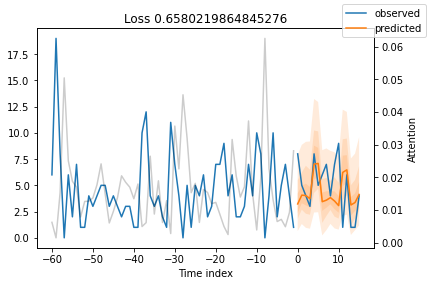

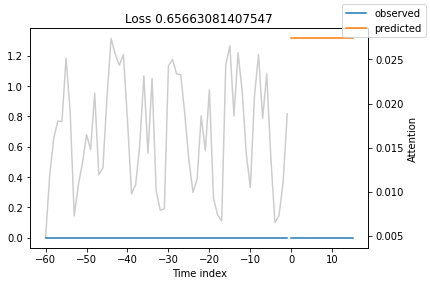

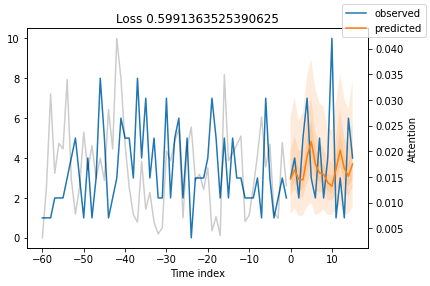

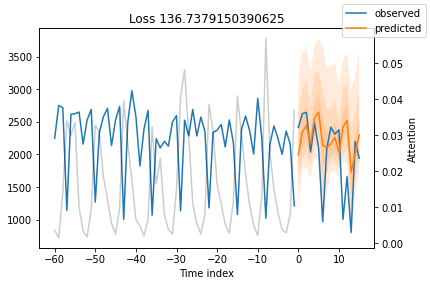

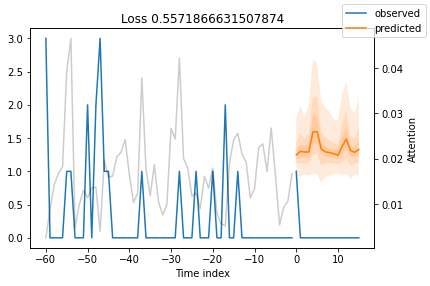

In [35]:
for idx in range(5):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

/opt/conda/lib/python3.7/site-packages/pytorch_forecasting/models/base_model.py:1564: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



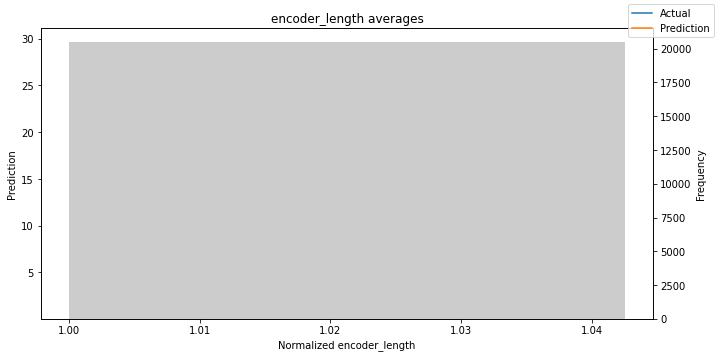

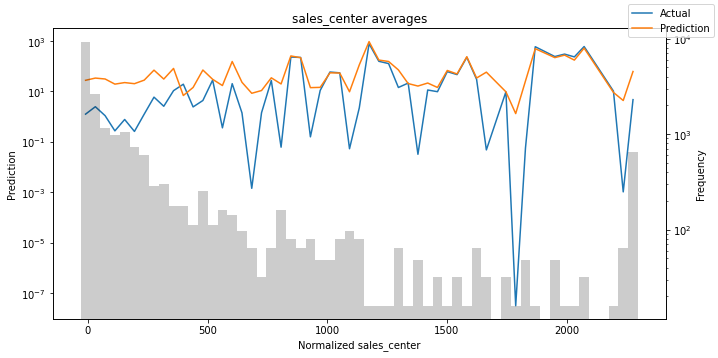

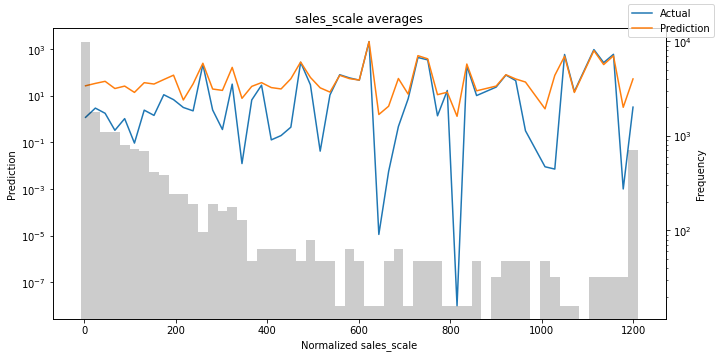

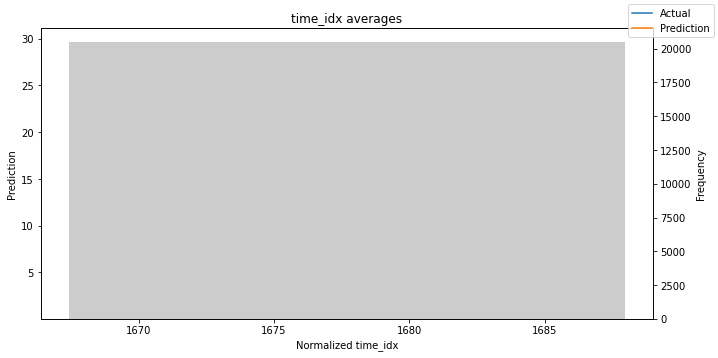

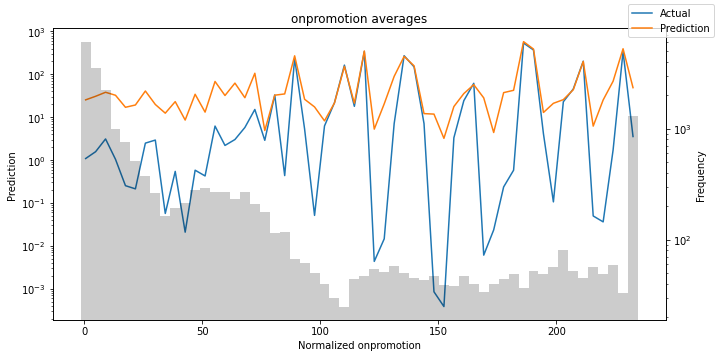

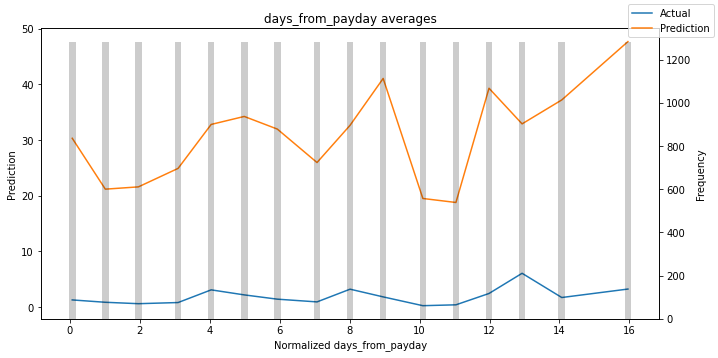

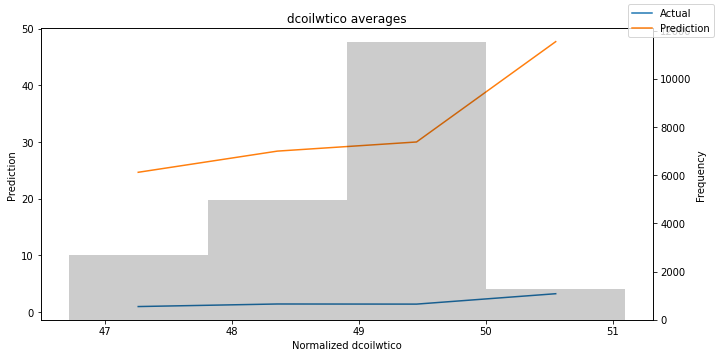

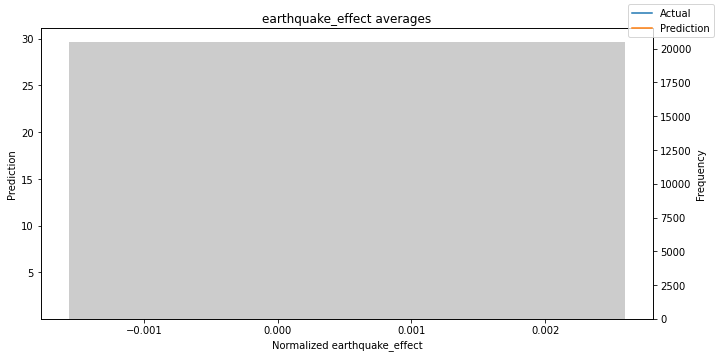

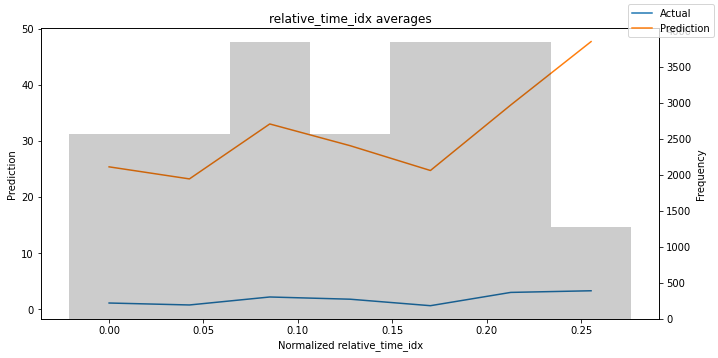

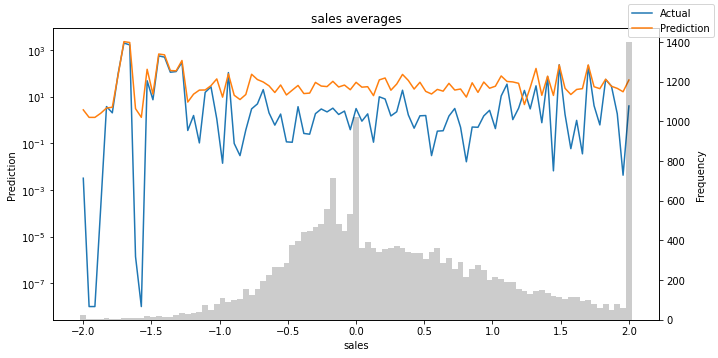

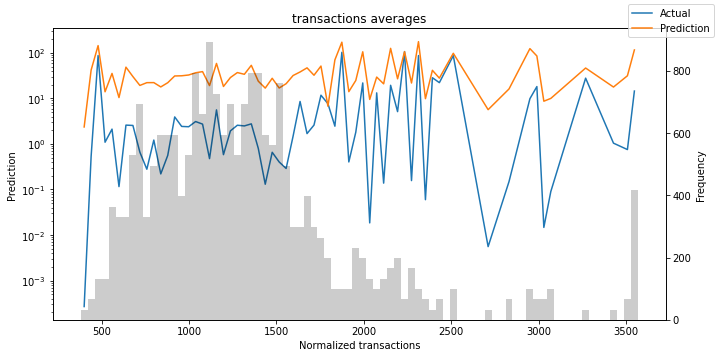

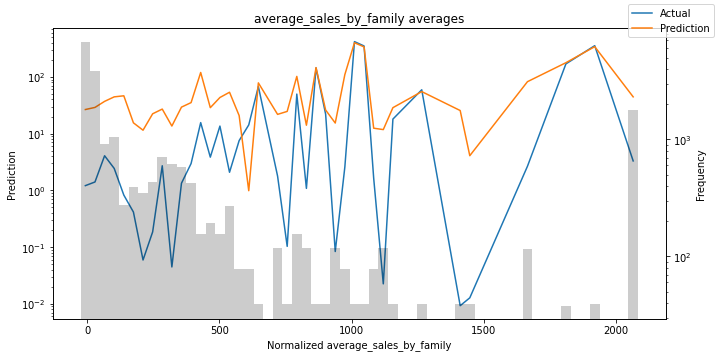

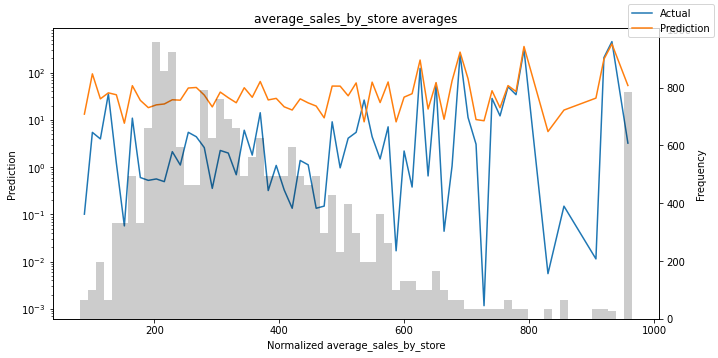

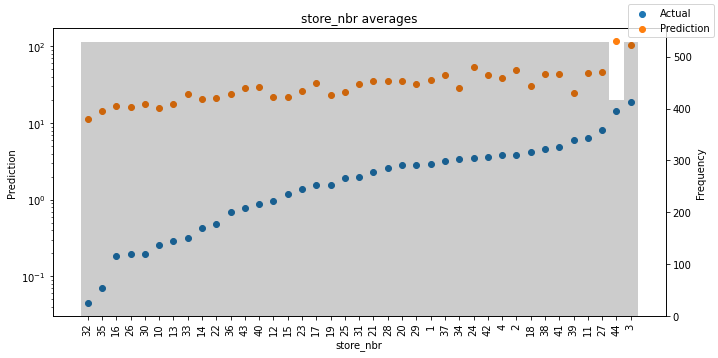

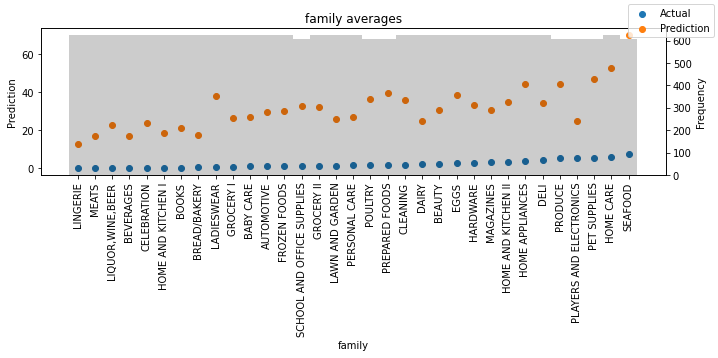

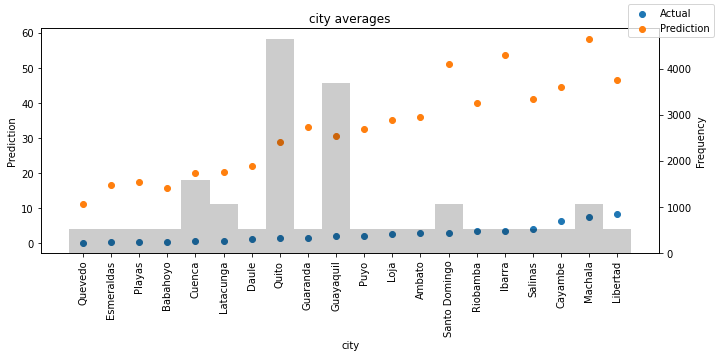

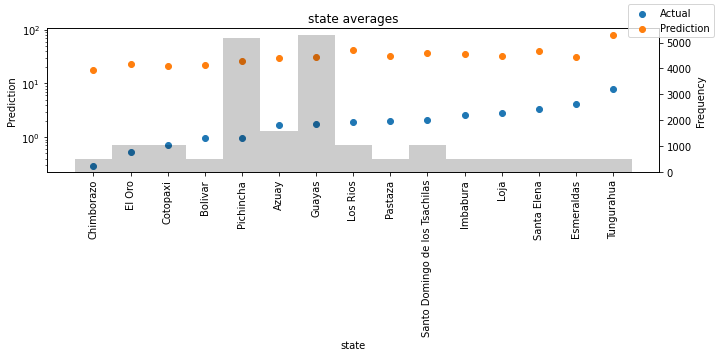

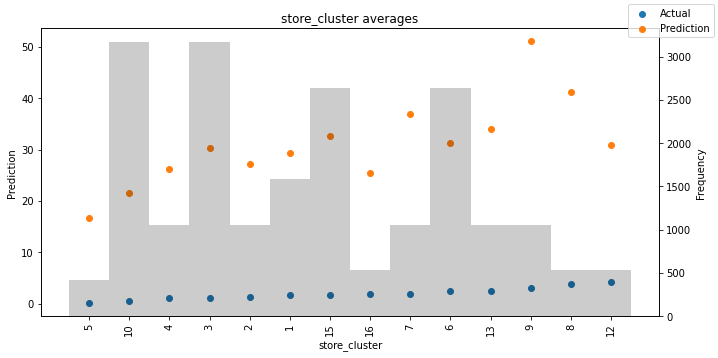

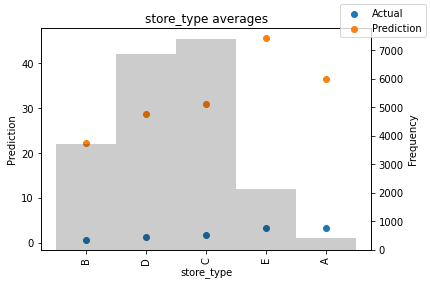

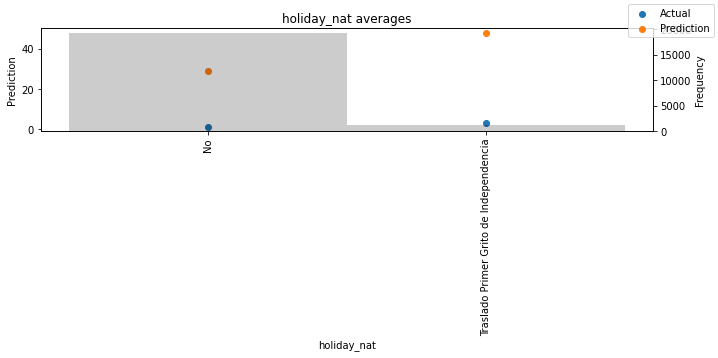

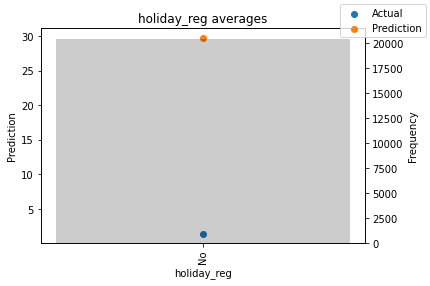

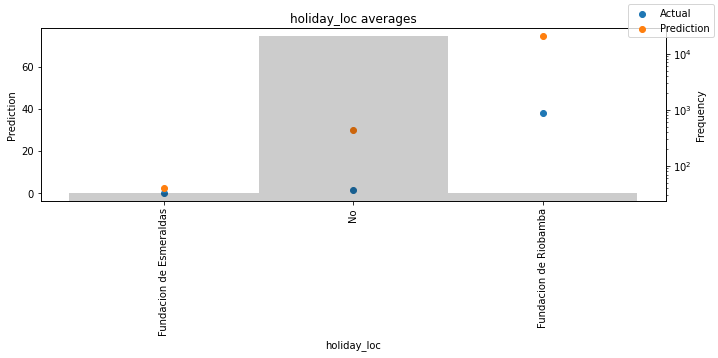

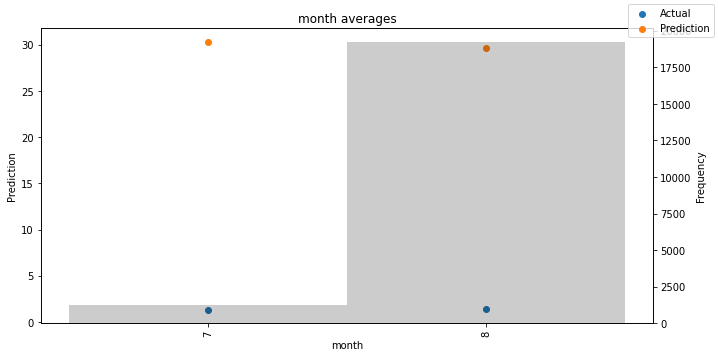

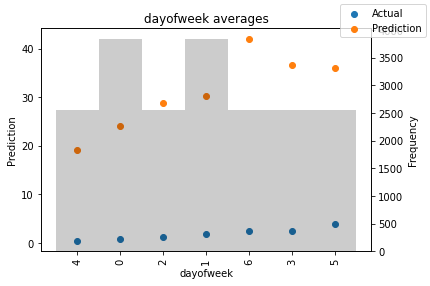

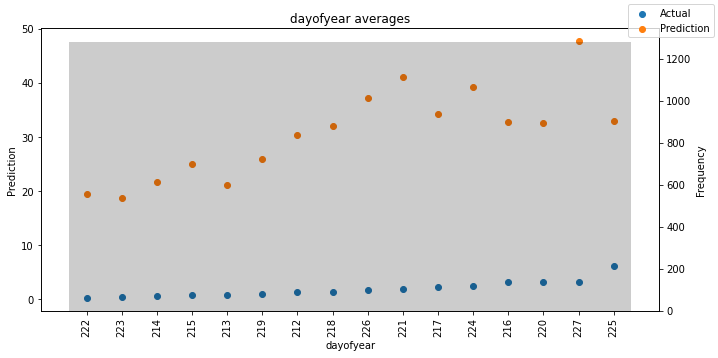

In [36]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [37]:
df_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,20.0
1,3000889,2017-08-16,1,BABY CARE,1.0
2,3000890,2017-08-16,1,BEAUTY,8.0
3,3000891,2017-08-16,1,BEVERAGES,560.0
4,3000892,2017-08-16,1,BOOKS,1.0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,54.0
28508,3029396,2017-08-31,9,PREPARED FOODS,10.0
28509,3029397,2017-08-31,9,PRODUCE,302.0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15.0


<a id="section-3"></a>
# Prediction

In [38]:
df_test = pd.merge(df_test, stores, on='store_nbr')



In [39]:
df_test

,id,date,store_nbr,family,onpromotion,city,state,store_type,store_cluster
0,3000888,2017-08-16,1,AUTOMOTIVE,20.0,Quito,Pichincha,D,13
1,3000889,2017-08-16,1,BABY CARE,1.0,Quito,Pichincha,D,13
2,3000890,2017-08-16,1,BEAUTY,8.0,Quito,Pichincha,D,13
3,3000891,2017-08-16,1,BEVERAGES,560.0,Quito,Pichincha,D,13
4,3000892,2017-08-16,1,BOOKS,1.0,Quito,Pichincha,D,13
...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,54.0,Quito,Pichincha,B,6
28508,3029396,2017-08-31,9,PREPARED FOODS,10.0,Quito,Pichincha,B,6
28509,3029397,2017-08-31,9,PRODUCE,302.0,Quito,Pichincha,B,6
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15.0,Quito,Pichincha,B,6


In [40]:

df_test = pd.merge(df_test, holidays_nat[['date','description']], on='date', how='left').rename(columns={'description': 'holiday_nat'})
df_test = pd.merge(df_test, holidays_reg[['date', 'locale_name', 'description']], left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left').rename(columns={'description': 'holiday_reg'}).drop(columns=['locale_name'])
df_test = pd.merge(df_test, holidays_loc[['date', 'locale_name', 'description']], left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left').rename(columns={'description': 'holiday_loc'}).drop(columns=['locale_name'])

df_test[["holiday_nat", "holiday_reg", "holiday_loc"]] = df_test[["holiday_nat", "holiday_reg", "holiday_loc"]].fillna("No")

df_test = pd.merge(df_test, oil, on='date', how='left')
df_test['dcoilwtico'] = df_test['dcoilwtico'].interpolate().fillna(method='bfill')

df_test['dayofweek'] = df_test['date'].dt.dayofweek.astype('str').astype('category')
df_test['month'] = df_test['date'].dt.month.astype('str').astype('category')
df_test['dayofyear'] = df_test['date'].dt.dayofyear.astype('str').astype('category')


for cat_col in ['holiday_nat', 'holiday_reg', 'holiday_loc','city','state' , 'store_type', 'store_cluster', 'store_nbr', 'family']:
    df_test[cat_col] = df_test[cat_col].astype(str).astype('category')

df_test['earthquake_effect'] = 0

df_test['days_from_payday'] = df_test['date'].apply(get_distance_from_paydays)
df_test['time_idx'] = (df_test['date'].dt.date - df_train['date'].dt.date.min()).dt.days

In [41]:
df_test

,id,date,store_nbr,family,onpromotion,city,state,store_type,store_cluster,holiday_nat,holiday_reg,holiday_loc,dcoilwtico,dayofweek,month,dayofyear,earthquake_effect,days_from_payday,time_idx
0,3000888,2017-08-16,1,AUTOMOTIVE,20.0,Quito,Pichincha,D,13,No,No,No,46.80,2,8,228,0,15,1688
1,3000889,2017-08-16,1,BABY CARE,1.0,Quito,Pichincha,D,13,No,No,No,46.80,2,8,228,0,15,1688
2,3000890,2017-08-16,1,BEAUTY,8.0,Quito,Pichincha,D,13,No,No,No,46.80,2,8,228,0,15,1688
3,3000891,2017-08-16,1,BEVERAGES,560.0,Quito,Pichincha,D,13,No,No,No,46.80,2,8,228,0,15,1688
4,3000892,2017-08-16,1,BOOKS,1.0,Quito,Pichincha,D,13,No,No,No,46.80,2,8,228,0,15,1688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,54.0,Quito,Pichincha,B,6,No,No,No,47.26,3,8,243,0,0,1703
28508,3029396,2017-08-31,9,PREPARED FOODS,10.0,Quito,Pichincha,B,6,No,No,No,47.26,3,8,243,0,0,1703
28509,3029397,2017-08-31,9,PRODUCE,302.0,Quito,Pichincha,B,6,No,No,No,47.26,3,8,243,0,0,1703
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15.0,Quito,Pichincha,B,6,No,No,No,47.26,3,8,243,0,0,1703


In [42]:
# select last 30 days from data (max_encoder_length is 24)
encoder_data = df_train[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]


last_data = df_train[df_train['time_idx'].isin([idx  -  prediction_steps for idx in df_test['time_idx'].unique()])]
last_data['time_idx'] = last_data['time_idx'] + prediction_steps
decoder_data = pd.merge(df_test[[col for col in df_test.columns if 'sales' not in col]], 
        last_data[['time_idx','store_nbr', 'family', 'sales', 'average_sales_by_family', 'average_sales_by_store' , 'transactions']],
        on = ['time_idx', 'store_nbr', 'family',]
        )

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
decoder_data

,id,date,store_nbr,family,onpromotion,city,state,store_type,store_cluster,holiday_nat,...,dayofweek,month,dayofyear,earthquake_effect,days_from_payday,time_idx,sales,average_sales_by_family,average_sales_by_store,transactions
0,3000888,2017-08-16,1,AUTOMOTIVE,20.0,Quito,Pichincha,D,13,No,...,2,8,228,0,15,1688,8.000,6.685185,352.325000,1872.0
1,3000889,2017-08-16,1,BABY CARE,1.0,Quito,Pichincha,D,13,No,...,2,8,228,0,15,1688,0.000,0.314815,352.325000,1872.0
2,3000890,2017-08-16,1,BEAUTY,8.0,Quito,Pichincha,D,13,No,...,2,8,228,0,15,1688,3.000,5.111111,352.325000,1872.0
3,3000891,2017-08-16,1,BEVERAGES,560.0,Quito,Pichincha,D,13,No,...,2,8,228,0,15,1688,2414.000,3620.444444,352.325000,1872.0
4,3000892,2017-08-16,1,BOOKS,1.0,Quito,Pichincha,D,13,No,...,2,8,228,0,15,1688,1.000,0.018519,352.325000,1872.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,54.0,Quito,Pichincha,B,6,No,...,3,8,243,0,0,1703,438.133,325.679815,564.741727,2155.0
28508,3029396,2017-08-31,9,PREPARED FOODS,10.0,Quito,Pichincha,B,6,No,...,3,8,243,0,0,1703,154.553,85.954129,564.741727,2155.0
28509,3029397,2017-08-31,9,PRODUCE,302.0,Quito,Pichincha,B,6,No,...,3,8,243,0,0,1703,2419.729,2316.832796,564.741727,2155.0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15.0,Quito,Pichincha,B,6,No,...,3,8,243,0,0,1703,121.000,46.851852,564.741727,2155.0


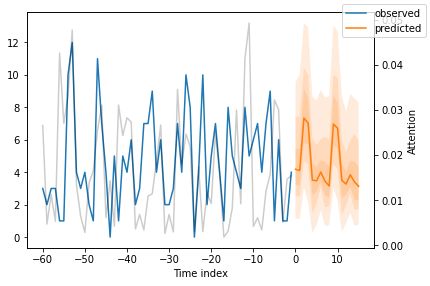

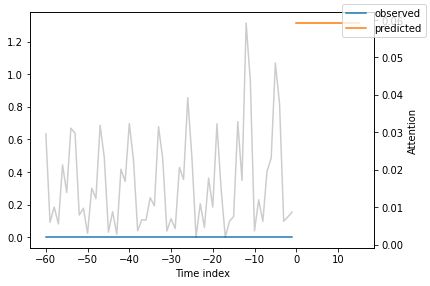

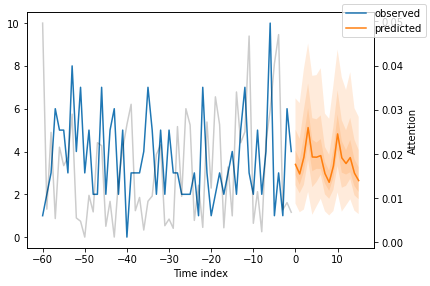

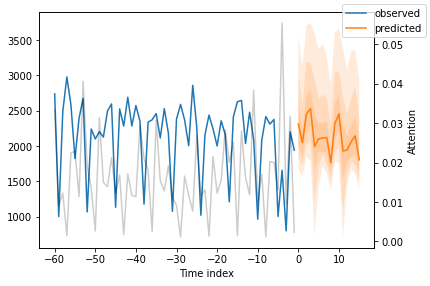

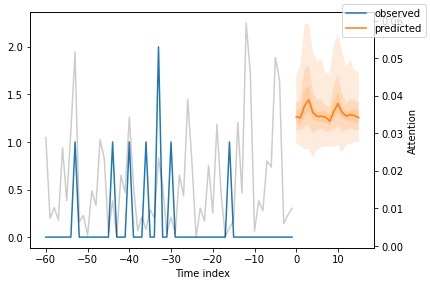

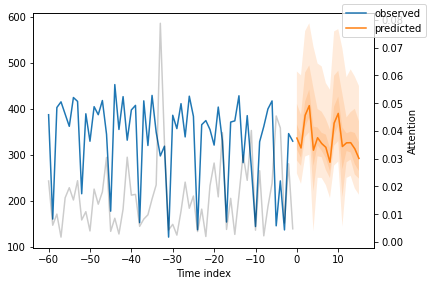

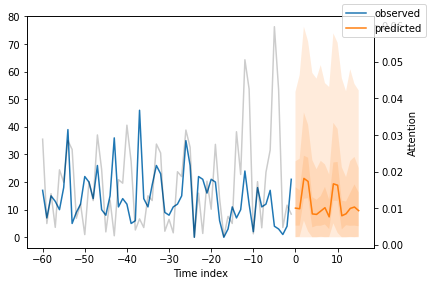

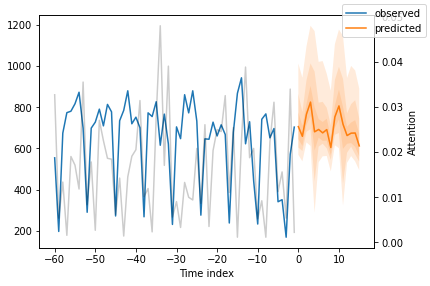

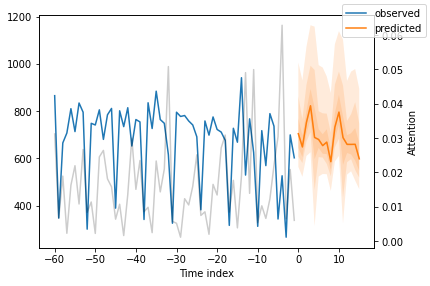

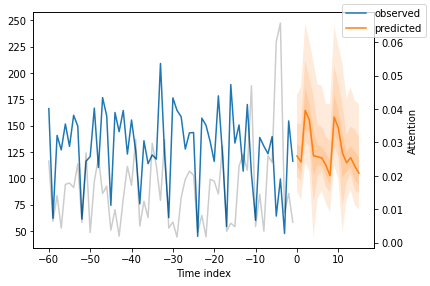

In [44]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x306 with 1 Axes>,
 'encoder_variables': <Figure size 504x432 with 1 Axes>,
 'decoder_variables': <Figure size 504x360 with 1 Axes>}

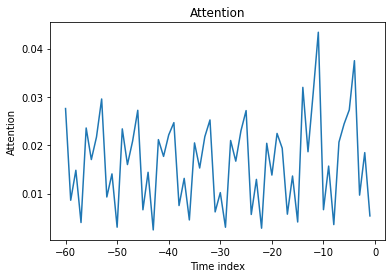

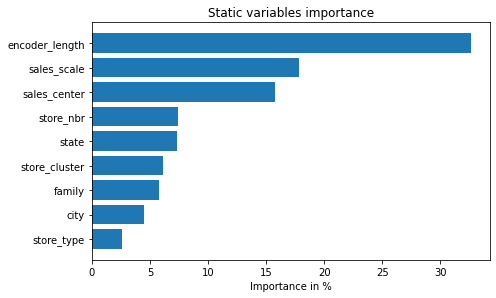

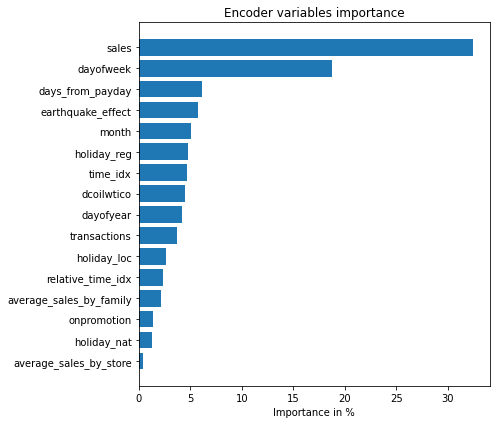

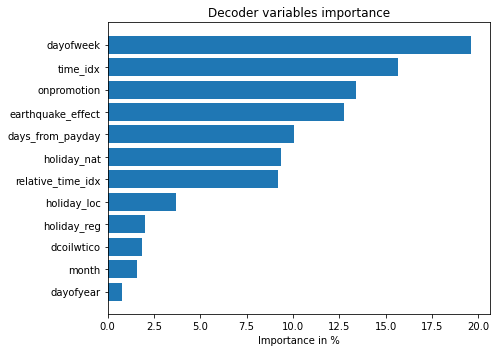

In [45]:
interpretation = best_tft.interpret_output(new_raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

### Reformat predictions for submission

In [46]:
predictions = best_tft.predict(new_prediction_data, mode="prediction", return_x=False)


In [47]:
predictions = pd.DataFrame(predictions.numpy()).T
predictions['date'] = sorted(df_test['date'].unique())
predictions = pd.melt(predictions, id_vars=['date'])
predictions = predictions.sort_values(['date', 'variable']).reset_index(drop=True)
df_test[['date', 'id', 'store_nbr', 'family']].sort_values(['date', 'store_nbr', 'family']).reset_index(drop=True)
df_test = df_test.join(predictions['value'])

In [48]:
import plotly.graph_objects as go 
import plotly.express as px
list_colors = px.colors.qualitative.Plotly
def plot_train_prediction(df_train, df_predictions, store="3", n_families=10, date_begin="2017-07-15", pred_time_col='date' , pred_col='value'):
    df_train_viz = df_train[(df_train['date'] > pd.to_datetime("2017-07-15"))&(df_train['store_nbr']==store)]
    fig = go.Figure()

    for i, family in enumerate(df_train_viz['family'].unique()[:10]):
        train = df_train_viz[df_train_viz['family']==family]
        pred = df_predictions[(df_predictions['family']==family)&(df_predictions['store_nbr']==store)]
        fig.add_trace(go.Scatter(x =train["date"], y=train["sales"], mode='lines', name=f'{family}_train', line=dict(color=list_colors[i])))
        fig.add_trace(go.Scatter(x =pred[pred_time_col], y=pred[pred_col], mode='lines', name=f'{family}_pred',  line=dict(color=list_colors[i])))

    fig.show()
    
plot_train_prediction(df_train, df_test, store="4")

In [49]:
df_test[['id', 'value']].rename(columns={"value": "sales"}).to_csv('submission.csv', index=False)